In [1]:
# ============================
# CARGA Y PREPROCESAMIENTO
# ============================

import pandas as pd
import numpy as np

ruta_ecoli = '../datasets/ecoli/ecoli.data'
df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)

# Separar características y etiquetas
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values
y_bin = np.where(y == 'cp', 1, 0)  # cp = clase minoritaria

X_min = X[y_bin == 1]
X_maj = X[y_bin == 0]
print("Instancias minoritarias:", len(X_min))
print("Instancias mayoritarias:", len(X_maj))


Instancias minoritarias: 143
Instancias mayoritarias: 193


C:\Users\User\AppData\Local\Temp\ipykernel_5496\15793575.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta_ecoli, header=None, delim_whitespace=True)


In [2]:
# ============================
# APLICAR LA TÉCNICA HÍBRIDA
# ============================
import sys
import os

# Agregar scripts al path
sys.path.append(os.path.abspath('../scripts'))

from alpha_distance_ar_adasyn import AlphaDistanceARADASYN

hibrido = AlphaDistanceARADASYN(m=5, beta=1.0, random_state=42)
X_syn = hibrido.fit_resample(X_min, X_maj)

print("Muestras sintéticas generadas:", X_syn.shape[0])

# Dataset balanceado resultante
X_resampled = np.vstack([X, X_syn])
y_resampled = np.hstack([y_bin, np.ones(len(X_syn))])


Muestras sintéticas generadas: 46


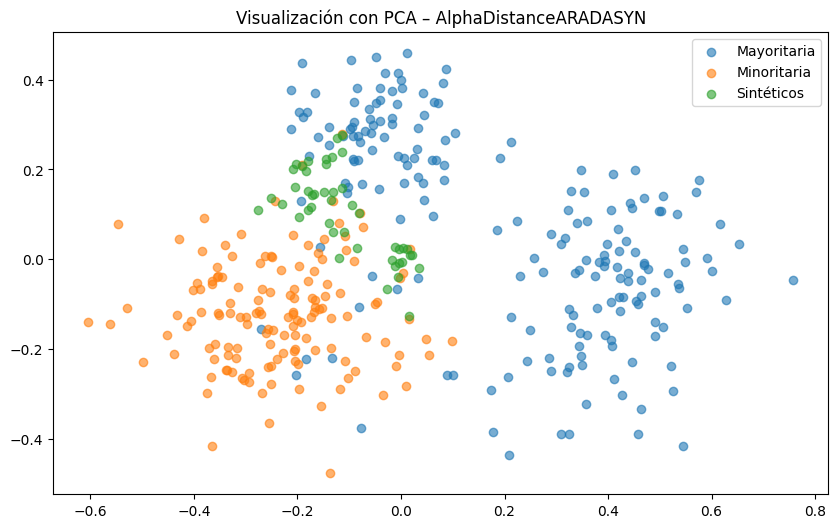

In [3]:
# ================================
# Visualización con PCA
# ================================
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reducir a 2D para visualizar
pca = PCA(n_components=2)
X_vis = pca.fit_transform(np.vstack([X_min, X_maj, X_syn]))

# Etiquetas de clase extendidas
y_vis = (
    [1] * len(X_min) +     # Clase minoritaria
    [0] * len(X_maj) +     # Clase mayoritaria
    [2] * len(X_syn)       # Sintéticos generados
)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_vis[np.array(y_vis) == 0, 0], X_vis[np.array(y_vis) == 0, 1], label="Mayoritaria", alpha=0.6)
plt.scatter(X_vis[np.array(y_vis) == 1, 0], X_vis[np.array(y_vis) == 1, 1], label="Minoritaria", alpha=0.6)
plt.scatter(X_vis[np.array(y_vis) == 2, 0], X_vis[np.array(y_vis) == 2, 1], label="Sintéticos", alpha=0.6)
plt.legend()
plt.title("Visualización con PCA – AlphaDistanceARADASYN")
plt.show()


In [4]:
# ================================
# Entrenar y evaluar con RandomForest
# ================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Dataset final balanceado
X_final = X_resampled
y_final = y_resampled

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# Entrenar modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Reporte
print("Reporte de clasificación – AlphaDistanceARADASYN\n")
print(classification_report(y_test, y_pred, digits=4))


Reporte de clasificación – AlphaDistanceARADASYN

              precision    recall  f1-score   support

         0.0     0.9600    0.9796    0.9697        49
         1.0     0.9846    0.9697    0.9771        66

    accuracy                         0.9739       115
   macro avg     0.9723    0.9746    0.9734       115
weighted avg     0.9741    0.9739    0.9739       115

